In [1]:
import torchvision 
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np
import pandas as pd
import os
import glob
import cv2
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn import cluster
import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
root_dir = './data/training'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('./data/training_frames_keypoints.csv')

In [3]:
# The even columns represent the x-axis value corresponding to each of the 68 key points of the face
# The odd columns represent the y-axis value corresponding to each of the 68 key points of the face
# The 1st column is the name of the image in the image directory
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [4]:
n = 0
image_name = data.iloc[n, 0]
key_pts = data.iloc[n, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


In [5]:
# print out some stats about the data
print('Number of images: ', data.shape[0])

Number of images:  3462


In [6]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

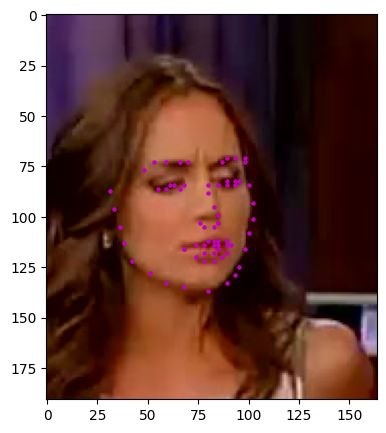

In [7]:
# Display a few different types of images by changing the index n

# select an image by index in our data frame
n = 777
image_name = data.iloc[n, 0]
key_pts = data.iloc[n, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_keypoints(cv2.cvtColor(cv2.imread(os.path.join('data/training/', image_name)), cv2.COLOR_BGR2RGB), key_pts)
plt.show()

In [9]:
class FaceData(Dataset):
    def __init__(self, df):
        super(FaceData).__init__()
        self.df = df
        self.df = df
        self.normalize = transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        )
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ix):
        """
        We are ensuring that key points (for x and y axes) are provided as a proportion of the original image's size.
        It is done because we have resized the image, so we need to resize the appropriate key points. 
        The expected output of the key points is the continuous value between 0 and 1.
        """
        img_path = './data/training/' + self.df.iloc[ix, 0]
        # read and scale the image
        img = cv2.imread(img_path)/255
        # normalize the output values (key points) as a proportion of the size of the original image
        kp = deepcopy(self.df.iloc[ix, 1:].tolist())
        kp_x = (np.array(kp[0::2]) / img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2]) / img.shape[0]).tolist()
        # return the key points kp2 and the image after preprocessing 
        kp2 = kp_x + kp_y
        kp2 = torch.tensor(kp2)
        img = self.preprocess_input(img)
        return img, kp2
    
    def preprocess_input(self, img):
        img = cv2.resize(img, (224, 224))
        img = torch.tensor(img).permute(2, 0, 1)
        img = self.normalize(img).float()
        return img.to(device)
    
    def load_img(self, ix):
        img_path = './data/training/' + self.df.iloc[ix, 0]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
        img = cv2.resize(img, (224, 224))
        return img

In [10]:
# Create training and test data split and establish training and test datasets and dataloader
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size = 0.25, random_state = 101, shuffle = True)

train_dataset = FaceData(train.reset_index(drop=True))
test_dataset = FaceData(test.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

In [11]:
# Define the model function and model's architecture to leverage the task of key points identification
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    # Overwrite and unfreeze the parameters of the last 2 layers of the model
    # Avg Pooling Layer
    model.avgpool = nn.Sequential(
        nn.Conv2d(512, 512, 3),
        nn.MaxPool2d(2),
        nn.Flatten()
    )
    # Classifier
    model.classifier = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 136),
        nn.Sigmoid() # returns the value in range from 0 to 1 as we need for our key point identification task
    )
    # Define the loss function and optimizer 
    criterion = nn.L1Loss() # L1 loss is the mean absolute error for our regression task (MAE)
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
    return model.to(device), criterion, optimizer

In [12]:
model, criterion, optimizer = get_model()

In [13]:
# Functions to train on a batch of data points and validate on the test dataset
def train_batch(img, kps, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    loss.backward()
    optimizer.step()
    return loss

# A function that returns the loss on test data and the predicted key points
def validate_batch(img, kps, model, criterion):
    model.eval()
    with torch.no_grad():
        _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    return _kps, loss


In [15]:
# Train the model
train_loss, test_loss = [], []
n_epochs = 50

for epoch in range(n_epochs):
    epoch_train_loss, epoch_test_loss = 0, 0
    for ix, (img,kps) in enumerate(train_loader):
        loss = train_batch(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss.item() 
    epoch_train_loss /= (ix+1)

    for ix,(img,kps) in enumerate(test_loader):
        ps, loss = validate_batch(img, kps, model, criterion)
        epoch_test_loss += loss.item() 
    epoch_test_loss /= (ix+1)

    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

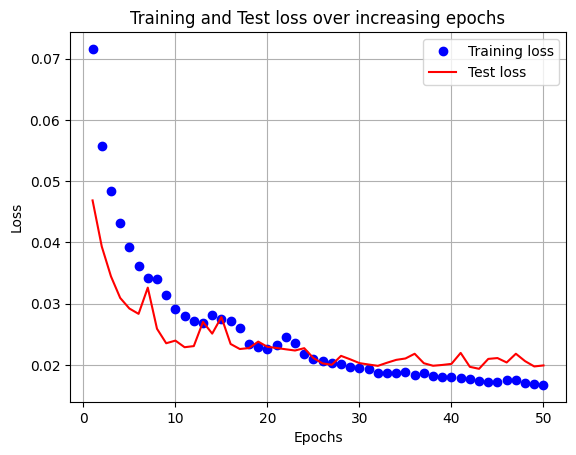

In [16]:
epochs = np.arange(50)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

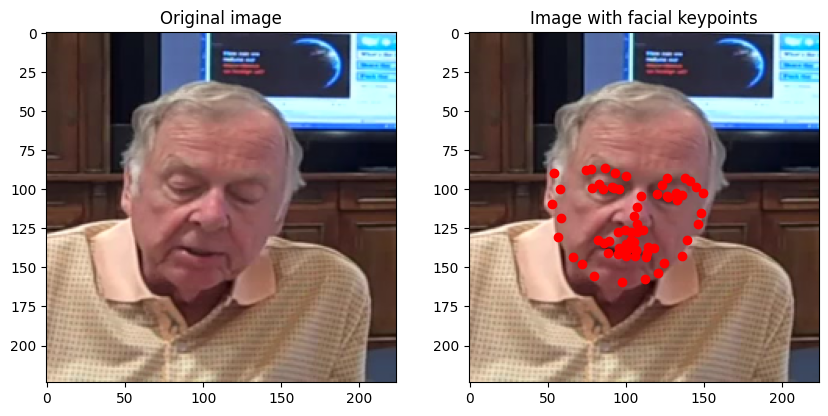

In [17]:
# Test model on a random test image index 
ix = 666
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')

im = test_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')

x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()

### [Automatic 2D and 3D facial key points detection](https://github.com/1adrianb/face-alignment)

In [ ]:
# !pip install -qU face-alignment
import face_alignment, cv2

# Define the face alignment method where you specify whether you want to fetch key point landmarks in 2D or 3D
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device='cpu')

# Read the input image for the face alignment
input = cv2.imread("./data/test/Andy_Rooney_21.jpg")
preds = fa.get_landmarks(input)[0]
print(preds.shape)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(figsize=(5,5))
plt.imshow(cv2.cvtColor(cv2.imread("./data/test/Andy_Rooney_21.jpg"), cv2.COLOR_BGR2RGB))
ax.scatter(preds[:,0], preds[:,1], marker='+', c='r')
plt.show()